<a href="https://colab.research.google.com/github/debjyoti003/Important-Colab-Notebooks/blob/main/BERT_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import re
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
os.chdir(r'/content/drive/MyDrive/')

In [5]:
with ZipFile(r'/content/drive/MyDrive/Disaster tweets prediction.zip', 'r') as zipObj:
   zipObj.extractall(r'/content/drive/MyDrive/Disaster tweets prediction')

In [6]:
os.chdir(r'/content/drive/MyDrive/Disaster tweets prediction')
data_files = os.listdir()
data_files

['sample_submission.csv',
 'test.csv',
 'train.csv',
 'tokenization.py',
 '__pycache__']

In [7]:
train_df = pd.read_csv(data_files[2])
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Text(0.5, 1.0, 'Bar Plot showing the count of target column')

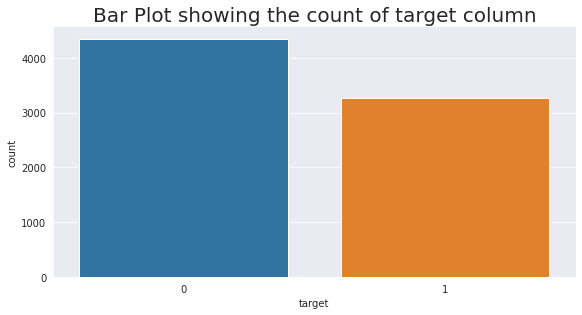

In [9]:
sns.set_style('darkgrid')
sns.catplot(x = "target",data = train_df, kind = "count",height=4,aspect=2)
plt.title('Bar Plot showing the count of target column', size = 20)

In [10]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [11]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 6.9MB/s 


In [12]:
import tensorflow_hub as hub
import sentencepiece
import tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


In [13]:
def cleaned_text(text):
    clean=re.sub("http\S+","",text)
    clean=re.sub("pic.twitter\S+","",clean)
    clean=re.sub("@\S+","",clean)
    clean = re.sub('#', '', clean)
    clean = clean.lower()
    return clean
train_df['cleaned_text'] = train_df['text'].apply(cleaned_text)
train_df.head()

,id,keyword,location,text,target,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


In [14]:
def word_count(text):
  text = text.split()
  length = len(text)
  return length

train_df['Word Count'] = train_df['cleaned_text'].apply(word_count)
train_df.head()

,id,keyword,location,text,target,cleaned_text,Word Count
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...,13
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,7
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,22
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord...",8
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...,16


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Frequency distribution of number of words for each tweet')

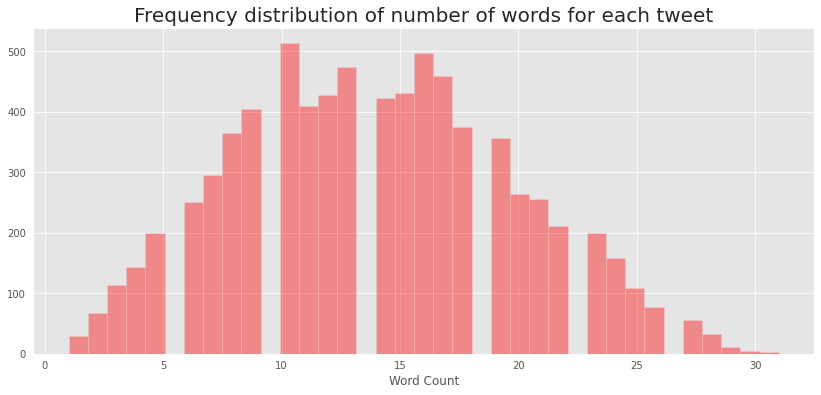

In [15]:
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
sns.distplot(train_df['Word Count'],kde = False,color="red")
plt.title("Frequency distribution of number of words for each tweet", size=20)

In [16]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [17]:
def bert_encode(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [44]:
print(bert_encode(train_df['cleaned_text'][0], tokenizer)[0])

[[ 101 1051  102 ...    0    0    0]
 [ 101 1057  102 ...    0    0    0]
 [ 101 1054  102 ...    0    0    0]
 ...
 [ 101 1037  102 ...    0    0    0]
 [ 101 1048  102 ...    0    0    0]
 [ 101 1048  102 ...    0    0    0]]


In [18]:
def build_model(bert_layer, max_len=100):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
from tensorflow import keras

In [23]:
max_len = 100
train_input = bert_encode(train_df.cleaned_text.values, tokenizer, max_len=max_len)
# test_input = bert_encode(test.Review.values, tokenizer, max_len=max_len)
train_labels = train_df['target']

In [24]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1)

Epoch 1/5
191/191 [==============================] - 91s 409ms/step - loss: 0.5046 - accuracy: 0.7640 - val_loss: 0.4218 - val_accuracy: 0.8260
Epoch 2/5
191/191 [==============================] - 78s 406ms/step - loss: 0.3761 - accuracy: 0.8521 - val_loss: 0.3813 - val_accuracy: 0.8365
Epoch 3/5
191/191 [==============================] - 78s 406ms/step - loss: 0.3218 - accuracy: 0.8834 - val_loss: 0.4224 - val_accuracy: 0.8359
Epoch 4/5
191/191 [==============================] - 78s 407ms/step - loss: 0.2711 - accuracy: 0.9044 - val_loss: 0.4368 - val_accuracy: 0.8332
Epoch 5/5
191/191 [==============================] - 78s 407ms/step - loss: 0.2229 - accuracy: 0.9227 - val_loss: 0.4859 - val_accuracy: 0.8293


In [28]:
model.save('/content/drive/MyDrive/Disaster tweets prediction/disaster_model.h5')